# CWE Analysis
The purpose of this pipeline is to collect metadata about the CWE. In particular view CWE-1003 as it's contains the weaknesses the NVD use for labeling. However we may also take a look at view CWE-1000 for completeness. 

In [1]:
import requests
import json
import certifi


def req_CWE(url, jfile=None, printj=True):
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0"
    }
    try:
        # Make the request
        reply = requests.get(
            url, headers=headers, timeout=100, verify="../resources/sectigo_chain.crt"
        )
        reply.raise_for_status()
        jreply = reply.json()

        if not printj:
            return jreply
        # Write the JSON response to a file
        if jfile is None:
            print(json.dumps(jreply, indent=4))
        else:
            with open("tmp/" + jfile, "w") as file:
                json.dump(
                    jreply, file, indent=4
                )  # Write JSON data to the file with indentation
            print("Data successfully written to 'tmp/" + jfile + "'")
        return jreply
    except Exception as exp:
        # Handle exceptions and write error details to the file
        if jfile is None:
            print(f"Exception -> {exp}")
            print(f"Request status -> {reply.status_code}")
        else:
            with open("tmp/" + jfile, "w") as file:
                error_message = {
                    "error": str(exp),
                    "status_code": reply.status_code if "reply" in locals() else None,
                }
                json.dump(error_message, file, indent=4)
            print(f"Exception occurred. Details written to 'tmp/" + jfile + "'")

Random tests to get a view into the CWE API and database.

In [ ]:
# temporary tests
url_view1003 = "https://cwe-api.mitre.org/api/v1/cwe/view/1003"
url_view1003_des = "https://cwe-api.mitre.org/api/v1/cwe/74/descendants?view=1003"
url_view1003_children = "https://cwe-api.mitre.org/api/v1/cwe/74/children?view=1003"
url_CWE_20_74_inf = "https://cwe-api.mitre.org/api/v1/cwe/weakness/20,74?view=1003"
# url_CWE_all1003_inf = 'https://cwe-api.mitre.org/api/v1/cwe/weakness?view=1003'
url_leaf1284 = "https://cwe-api.mitre.org/api/v1/cwe/1284/children?view=1003"
print(len(req_CWE(url_view1003, "view_CWE-1003.json")["Views"][0]["Members"]))
req_CWE(url_view1003_des, "view_CWE-1003_desc_CWE-74.json")
req_CWE(url_view1003_children, "view_CWE-1003_children_CWE-74.json")
req_CWE(url_CWE_20_74_inf, "CWE-20,74_weakness.json")
# req_CWE(url_CWE_all1003_inf, 'CWE-1003_weakness.json')
req_CWE(url_leaf1284, "url_leaf1284.json")

Extracting relevant views using the CWE API

In [2]:
import pickle
import time
import sys


# sys.setrecursionlimit(2000)
def rec_expand(view, cweID, id_list):
    childrenURL = (
        "https://cwe-api.mitre.org/api/v1/cwe/" + cweID + "/children?view=" + view
    )
    childrenj = req_CWE(childrenURL, printj=False)
    for child in childrenj:
        headID = child["ID"]
        if headID in id_list:
            continue
        id_list.append(headID)
        id_list = rec_expand(view, headID, id_list)

    return id_list


def chunkl(lst, ch_size):
    chunks = []
    for i in range(0, len(lst), ch_size):
        chunks.append(lst[i : i + ch_size])
    return chunks


def get_weaknesses_from_id_list(view, id_list, save=False):
    weaknessesURL_header = "https://cwe-api.mitre.org/api/v1/cwe/weakness/"
    ch_size = 200
    id_chunks = chunkl(id_list, ch_size)
    jview_complete = {"Weaknesses": []}
    for id_chunk in id_chunks:
        weaknessesURL = weaknessesURL_header + ",".join(id_chunk)
        jresp = req_CWE(weaknessesURL, printj=False)

        if not isinstance(jresp, dict):
            raise ValueError(f"Expected JSON object (dict), but got {type(jresp)}")
        if "Weaknesses" not in jresp:
            raise KeyError(f"Missing 'Weaknesses' key in response: {jresp}")

        jview_complete["Weaknesses"].extend(jresp["Weaknesses"])
        # debug print
        print("resulting API request " + weaknessesURL)

    print("Number of weaknesses extracted:\t", len(id_list))

    # debug print
    print("Duplicate ID's?", len(id_list) > len(set(id_list)))

    if save:
        fsave_name = (
            "view_CWE-"
            + view
            + ("_all_weaknesses" if expand else "_head_weaknesses")
            + ".json"
        )
        with open("tmp/" + fsave_name, "w") as file:
            json.dump(
                jview_complete, file, indent=4
            )  # Write JSON data to the file with indentation
        print("Data successfully written to 'tmp/" + fsave_name + "'")
    return jview_complete


def get_weaknesses_from_view(view, expand=False, save=False):
    viewURL = "https://cwe-api.mitre.org/api/v1/cwe/view/" + view
    weaknessesURL_header = "https://cwe-api.mitre.org/api/v1/cwe/weakness/"
    id_list = []
    jview = req_CWE(viewURL, printj=False)
    for member in jview["Views"][0]["Members"]:
        headID = member["CweID"]
        if headID not in id_list:
            id_list.append(headID)
        if expand:
            id_list = rec_expand(view, headID, id_list)
        # time.sleep(1)

    return get_weaknesses_from_id_list(view, id_list, save)

In [11]:
jview1003_complete = get_weaknesses_from_view("1003", True, True)

# Save jview1003_complete using pickle
pickle_file = "tmp/jview1003_complete.pkl"
with open(pickle_file, "wb") as file:
    pickle.dump(jview1003_complete, file)
print(f"Data successfully saved to '{pickle_file}' using pickle.")

Exception -> HTTPSConnectionPool(host='cwe-api.mitre.org', port=443): Max retries exceeded with url: /api/v1/cwe/view/1003 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))


UnboundLocalError: local variable 'reply' referenced before assignment

In [74]:
import pandas as pd


def rec_expand_path(cweID: str, weaknesses, path_df):
    if not path_df[path_df["ID"] == cweID].empty:
        return path_df
    rw_list = weaknesses.loc[weaknesses["ID"] == cweID, "RelatedWeaknesses"].values
    if len(rw_list) == 0 or len(rw_list[0]) == 0 or not isinstance(rw_list[0], list):
        new_row = pd.DataFrame([{"ID": cweID, "NumPaths": 1, "Paths": [[cweID]]}])
        path_df = pd.concat([path_df, new_row], ignore_index=True)
        return path_df

    rw = rw_list[0]

    if not rw:
        new_row = pd.DataFrame([{"ID": cweID, "NumPaths": 1, "Paths": [[cweID]]}])
        path_df = pd.concat([path_df, new_row], ignore_index=True)
        return path_df

    paths = []
    num_paths = 0
    for w in rw:
        cid = w["CweID"]
        path_df = rec_expand_path(cid, weaknesses, path_df)
        num_paths += path_df[path_df["ID"] == cid].NumPaths.values[0]
        paths += [p + [cweID] for p in path_df[path_df["ID"] == cid].Paths.values[0]]

    new_row = pd.DataFrame([{"ID": cweID, "NumPaths": num_paths, "Paths": paths}])
    path_df = pd.concat([path_df, new_row], ignore_index=True)
    return path_df


def get_paths(view, df_weaknesses, combine=False):
    df_weak = df_weaknesses.copy()
    df_weak["RelatedWeaknesses"] = df_weak["RelatedWeaknesses"].apply(
        lambda weaknesses: (
            [w for w in weaknesses if w["ViewID"] == view]
            if isinstance(weaknesses, list)
            else []
        )
    )
    df_weak_org = df_weak.copy()

    # debug
    # display(df_weak_org[df_weak_org['RelatedWeaknesses'].apply(
    #    lambda weaknesses: [w for w in weaknesses if w['Nature'] == 'PeerOf'] != [] if isinstance(weaknesses, list) else False)])

    df_weak["RelatedWeaknesses"] = df_weak["RelatedWeaknesses"].apply(
        lambda weaknesses: (
            [w for w in weaknesses if w["Nature"] == "ChildOf"]
            if isinstance(weaknesses, list)
            else []
        )
    )

    # display(df_weaknesses)
    path_df = pd.DataFrame(columns=["ID", "NumPaths", "Paths"])
    for cweID in df_weak["ID"]:
        path_df = rec_expand_path(cweID, df_weak, path_df)

    path_df["ID"] = path_df["ID"].astype(str)
    df_weak["ID"] = df_weak["ID"].astype(str)
    if combine:
        return pd.merge(df_weak_org, path_df, on="ID")
    return path_df

In [75]:
def get_children(view, df_weaknesses, combine=False):
    # clean relations
    df_weak = df_weaknesses.copy()
    df_weak["RelatedWeaknesses"] = df_weak["RelatedWeaknesses"].apply(
        lambda weaknesses: (
            [w for w in weaknesses if w["ViewID"] == view]
            if isinstance(weaknesses, list)
            else []
        )
    )
    df_weak_org = df_weak.copy()
    df_weak["RelatedWeaknesses"] = df_weak["RelatedWeaknesses"].apply(
        lambda weaknesses: (
            [w for w in weaknesses if w["Nature"] == "ChildOf"]
            if isinstance(weaknesses, list)
            else []
        )
    )

    children_df = pd.DataFrame(columns=["ID", "Children"])
    for cweID in df_weak["ID"].to_list():
        children = []
        for row in df_weak.iterrows():
            if cweID in [w["CweID"] for w in row[1]["RelatedWeaknesses"]]:
                children.append(row[1]["ID"])

        new_row = pd.DataFrame([{"ID": cweID, "Children": children}])
        children_df = pd.concat([children_df, new_row], ignore_index=True)

    if combine:
        return pd.merge(df_weak_org, children_df, on="ID")

    return children_df

In [71]:
import pickle

pickle_file = "tmp/jview1003_complete.pkl"
with open(pickle_file, "rb") as file:
    jview1003_complete = pickle.load(file)
df_view1003 = pd.json_normalize(jview1003_complete["Weaknesses"], sep="_")
print(df_view1003.loc[df_view1003["ID"] == "20", "RelatedWeaknesses"].values)
df_view1003_complete = pd.DataFrame(df_view1003)
# display(df_view1003_complete[:5])
# display(df_view1003_complete[['ID', 'RelatedWeaknesses']])
path_df = get_paths("1003", df_view1003_complete, True)
path_df = get_children("1003", path_df, True)
display(path_df)
# display(df_view1003_complete[:5])
# display(df_view1003_complete[df_view1003_complete['ID'] == '20']['S'])

[list([{'Nature': 'ChildOf', 'CweID': '707', 'ViewID': '1000', 'Ordinal': 'Primary'}, {'Nature': 'PeerOf', 'CweID': '345', 'ViewID': '1000', 'Ordinal': 'Primary'}, {'Nature': 'CanPrecede', 'CweID': '22', 'ViewID': '1000'}, {'Nature': 'CanPrecede', 'CweID': '41', 'ViewID': '1000'}, {'Nature': 'CanPrecede', 'CweID': '74', 'ViewID': '1000'}, {'Nature': 'CanPrecede', 'CweID': '119', 'ViewID': '1000'}, {'Nature': 'CanPrecede', 'CweID': '770', 'ViewID': '1000'}])]


,ID,Name,Abstraction,Structure,Status,Diagram,Description,ExtendedDescription,LikelihoodOfExploit,RelatedWeaknesses,...,MappingNotes_Usage,MappingNotes_Rationale,MappingNotes_Comments,MappingNotes_Reasons,MappingNotes_Suggestions,WeaknessOrdinalities,AlternateTerms,AffectedResources,FunctionalAreas,BackgroundDetails


,ID,Name,Abstraction,Structure,Status,Diagram,Description,ExtendedDescription,LikelihoodOfExploit,RelatedWeaknesses,...,MappingNotes_Reasons,MappingNotes_Suggestions,WeaknessOrdinalities,AlternateTerms,AffectedResources,FunctionalAreas,BackgroundDetails,NumPaths,Paths,Children
0,20,Improper Input Validation,Class,Simple,Stable,/data/images/CWE-20-Diagram.png,"The product receives input or data, but it doe...",\n\nInput validation is a frequently-used tech...,High,[],...,"[Frequent Misuse, Frequent Misinterpretation, ...","[{'CweID': '1284', 'Comment': 'Specified Quant...",NaN,NaN,NaN,NaN,NaN,1,[[20]],"[1284, 129]"
1,1284,Improper Validation of Specified Quantity in I...,Base,Simple,Incomplete,NaN,The product receives input that is expected to...,"\n\nSpecified quantities include size, length,...",NaN,"[{'Nature': 'ChildOf', 'CweID': '20', 'ViewID'...",...,[Acceptable-Use],NaN,NaN,NaN,NaN,NaN,NaN,1,"[[20, 1284]]",[]
2,129,Improper Validation of Array Index,Variant,Simple,Draft,NaN,The product uses untrusted input when calculat...,NaN,High,"[{'Nature': 'ChildOf', 'CweID': '20', 'ViewID'...",...,[Acceptable-Use],NaN,"[{'Ordinality': 'Resultant', 'Description': 'T...","[{'Term': 'out-of-bounds array index'}, {'Term...",[Memory],NaN,NaN,1,"[[20, 129]]",[]
3,74,Improper Neutralization of Special Elements in...,Class,Simple,Incomplete,NaN,The product constructs all or part of a comman...,Software or other automated logic has certain ...,High,[],...,"[Frequent Misuse, Abstraction]",NaN,[{'Ordinality': 'Primary'}],NaN,NaN,NaN,NaN,1,[[74]],"[1236, 77, 78, 79, 88, 89, 91, 917, 94]"
4,1236,Improper Neutralization of Formula Elements in...,Base,Simple,Incomplete,NaN,The product saves user-provided information in...,User-provided data is often saved to tradition...,NaN,"[{'Nature': 'ChildOf', 'CweID': '74', 'ViewID'...",...,[Acceptable-Use],NaN,NaN,"[{'Term': 'CSV Injection'}, {'Term': 'Formula ...",NaN,NaN,NaN,1,"[[74, 1236]]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,913,Improper Control of Dynamically-Managed Code R...,Class,Simple,Incomplete,NaN,The product does not properly restrict reading...,Many languages offer powerful features that al...,NaN,[],...,[Abstraction],NaN,NaN,NaN,NaN,NaN,NaN,1,[[913]],"[1321, 470, 502]"
126,1321,Improperly Controlled Modification of Object P...,Variant,Simple,Incomplete,NaN,The product receives input from an upstream co...,\n\nBy adding or modifying attributes of an ob...,NaN,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...",...,[Acceptable-Use],NaN,NaN,NaN,NaN,NaN,NaN,1,"[[913, 1321]]",[]
127,470,Use of Externally-Controlled Input to Select C...,Base,Simple,Draft,NaN,The product uses external input with reflectio...,If the product uses external inputs to determi...,NaN,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...",...,[Acceptable-Use],NaN,NaN,[{'Term': 'Reflection Injection'}],NaN,NaN,NaN,1,"[[913, 470]]",[]
128,502,Deserialization of Untrusted Data,Base,Simple,Draft,/data/images/CWE-502-Diagram.png,The product deserializes untrusted data withou...,NaN,Medium,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...",...,[Acceptable-Use],NaN,NaN,"[{'Term': 'Marshaling, Unmarshaling', 'Descrip...",NaN,NaN,[Serialization and deserialization refer to th...,1,"[[913, 502]]",[]


In [72]:
from datasets import Dataset

df_view1003_complete = pd.DataFrame(
    pd.json_normalize(jview1003_complete["Weaknesses"], sep="_")
)
df_view1003_complete = get_paths("1003", df_view1003_complete, True)
df_view1003_complete = get_children("1003", df_view1003_complete, True)
ds_view1003_complete = Dataset.from_pandas(df_view1003_complete)
ds_view1003_complete.push_to_hub("Eathus/cwe_view1003_raw_list")

,ID,Name,Abstraction,Structure,Status,Diagram,Description,ExtendedDescription,LikelihoodOfExploit,RelatedWeaknesses,...,MappingNotes_Usage,MappingNotes_Rationale,MappingNotes_Comments,MappingNotes_Reasons,MappingNotes_Suggestions,WeaknessOrdinalities,AlternateTerms,AffectedResources,FunctionalAreas,BackgroundDetails


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/cwe_view1003_raw_list/commit/9e15b735e7d90aac52e8be843cdf924d5726371b', commit_message='Upload dataset', commit_description='', oid='9e15b735e7d90aac52e8be843cdf924d5726371b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/cwe_view1003_raw_list', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/cwe_view1003_raw_list'), pr_revision=None, pr_num=None)

## View CWE-1003

In [ ]:
# Now you can use jview1003_complete as a Python object
# print(json.dumps(jview1003_complete, indent=4))
df_view1003_complete = pd.DataFrame(
    pd.json_normalize(jview1003_complete["Weaknesses"], sep="_")
)
# display(df_view1003_complete[:5])
# display(df_view1003_complete[['ID', 'RelatedWeaknesses']])
df_view1003_complete_paths = get_paths("1003", df_view1003_complete, True)
display(df_view1003_complete_paths)
# display(*df_view1003_complete['RelatedWeaknesses'])
# display(df_view1003_complete[:5])
# display(df_view1003_complete[df_view1003_complete['ID'] == '20']['S'])

In [ ]:
i = 1
while len(df_view1003_complete_paths[df_view1003_complete_paths["NumPaths"] >= i]) != 0:
    print("All CWEs with", i, "path(s)")
    paths = df_view1003_complete_paths[df_view1003_complete_paths["NumPaths"] == i]
    display(paths)
    print(len(paths))
    i += 1

,Nature,Proportion
0,ChildOf,1.0


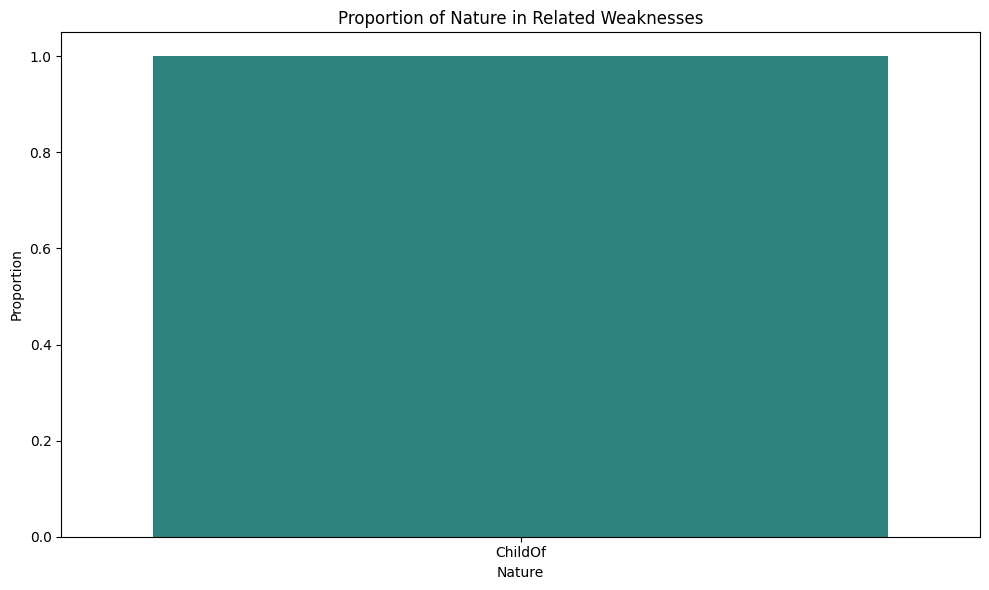

Nature
ChildOf    1.0
Name: proportion, dtype: float64

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt


def rwn_distribution(jview, view, normalize=False, plot=True):
    df = pd.DataFrame(pd.json_normalize(jview["Weaknesses"], sep="_"))
    df["RelatedWeaknesses"] = df["RelatedWeaknesses"].apply(
        lambda weaknesses: (
            [w for w in weaknesses if w["ViewID"] == view]
            if isinstance(weaknesses, list)
            else []
        )
    )

    # display(*df['RelatedWeaknesses'])
    df_rw = pd.json_normalize(df["RelatedWeaknesses"].explode().dropna())
    data = df_rw["Nature"].value_counts(normalize=normalize)

    if plot:
        data_df = data.reset_index()
        data_df.columns = ["Nature", ("Proportion" if normalize else "Count")]
        display(data_df)
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="Nature",
            y=("Proportion" if normalize else "Count"),
            hue="Nature",
            data=data_df,
            palette="viridis",
        )

        # Add labels and title
        plt.title("Proportion of Nature in Related Weaknesses")

        # Show the plot
        plt.tight_layout()
        plt.show()

    return data


rwn_distribution(jview1003_complete, "1003", True)

,Usage,Count
0,Allowed,83
1,Allowed-with-Review,29
2,Discouraged,18


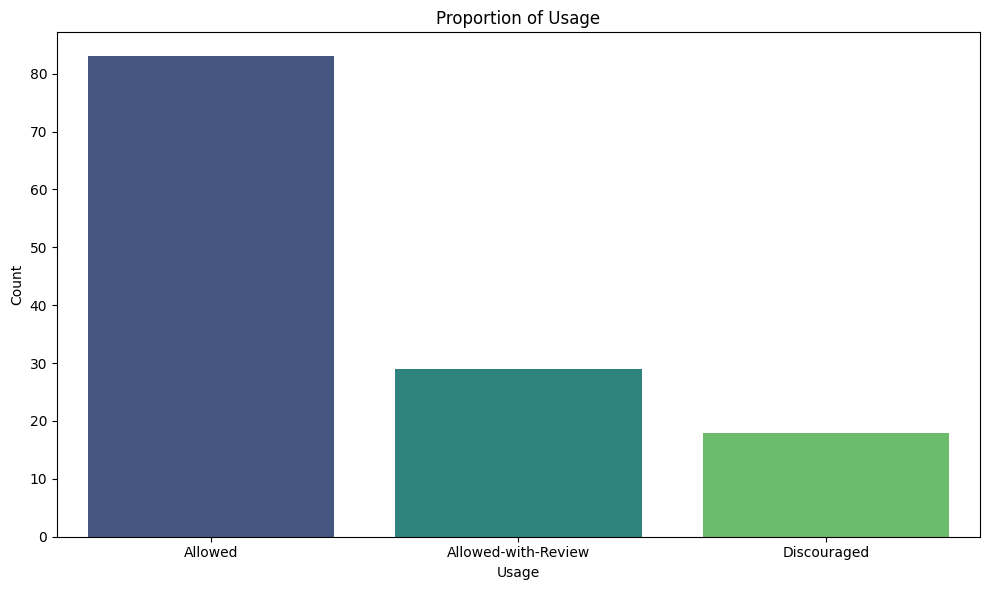

MappingNotes_Usage
Allowed                83
Allowed-with-Review    29
Discouraged            18
Name: count, dtype: int64

In [14]:
def usage_distribution(jview, plot=True, normalize=False):
    df = pd.DataFrame(pd.json_normalize(jview["Weaknesses"], sep="_"))
    data = df["MappingNotes_Usage"].value_counts(normalize=normalize)
    if plot:
        data_df = data.reset_index()
        data_df.columns = ["Usage", ("Proportion" if normalize else "Count")]
        display(data_df)
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="Usage",
            y=("Proportion" if normalize else "Count"),
            hue="Usage",
            data=data_df,
            palette="viridis",
        )

        # Add labels and title
        plt.title("Proportion of Usage")

        # Show the plot
        plt.tight_layout()
        plt.show()

    return data


usage_distribution(jview1003_complete)

In [15]:
def view_max_depth(jview, view):
    df = pd.DataFrame(pd.json_normalize(jview["Weaknesses"], sep="_"))
    df_paths = get_paths(view, df)
    path_array = df_paths["Paths"].values
    path_depths = [len(x) for x in path_array]
    return max(path_depths)


view_max_depth(jview1003_complete, "1003")

1

,Abstraction,Count
0,Base,81
1,Class,40
2,Variant,5
3,Compound,2
4,Pillar,2


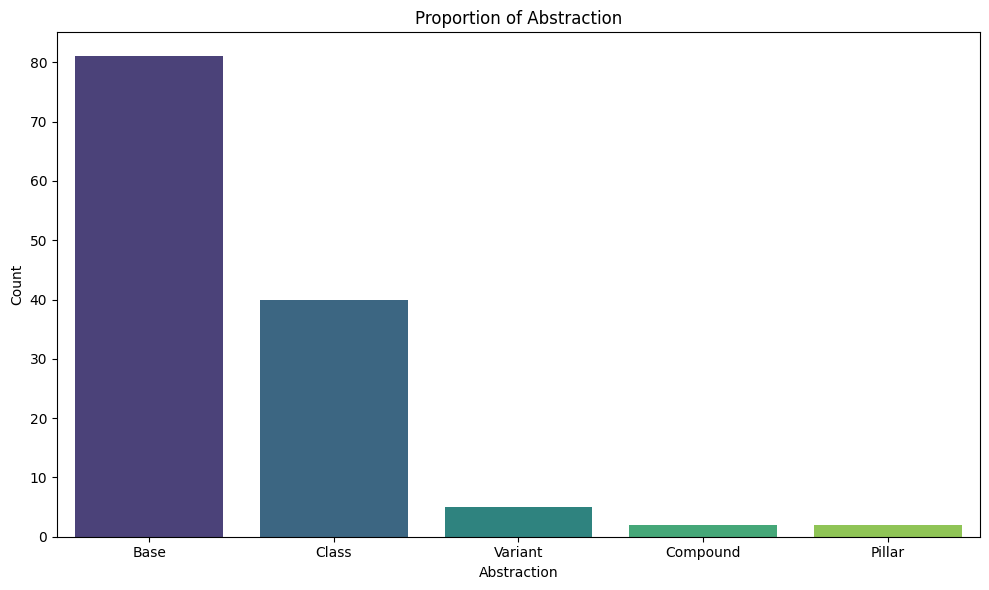

Abstraction
Base        81
Class       40
Variant      5
Compound     2
Pillar       2
Name: count, dtype: int64

In [81]:
def abstraction_distr(jview, plot=True, normalize=False):
    df = pd.DataFrame(pd.json_normalize(jview["Weaknesses"], sep="_"))
    data = df["Abstraction"].value_counts(normalize=normalize)
    if plot:
        data_df = data.reset_index()
        data_df.columns = ["Abstraction", ("Proportion" if normalize else "Count")]
        display(data_df)
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="Abstraction",
            y=("Proportion" if normalize else "Count"),
            hue="Abstraction",
            data=data_df,
            palette="viridis",
        )

        # Add labels and title
        plt.title("Proportion of Abstraction")

        # Show the plot
        plt.tight_layout()
        plt.show()

    return data


abstraction_distr(jview1003_complete)

## View CWE-1000

In [ ]:
jview1000_complete = get_weaknesses_from_view("1000", True, True)

# Save jview1003_complete using pickle

pickle1000_file = "tmp/jview1000_complete.pkl"
with open(pickle1000_file, "wb") as file:
    pickle.dump(jview1000_complete, file)
print(f"Data successfully saved to '{pickle1000_file}' using pickle.")

In [7]:
import json

with open("tmp/view_CWE-1000_all_weaknesses.json", "r") as f:
    json_data = json.load(f)  # Load

with open("tmp/jview1000_complete.pkl", "wb") as f:
    pickle.dump(json_data, f)  # Save JSON object as a pickle file

In [76]:
import pickle
import pandas as pd
import pandas

pickle_file = "tmp/jview1000_complete.pkl"
with open(pickle_file, "rb") as file:
    jview1000_complete = pickle.load(file)

df_view1000_complete = pd.DataFrame(
    pd.json_normalize(jview1000_complete["Weaknesses"], sep="_")
)

df_view1000_path_info = get_paths("1000", df_view1000_complete)
# display(*df_view1000_complete['RelatedWeaknesses'])

In [77]:
from datasets import Dataset

df_view1000_complete = pd.DataFrame(
    pd.json_normalize(jview1000_complete["Weaknesses"], sep="_")
)
df_view1000_complete = get_paths("1000", df_view1000_complete, True)
df_view1000_complete = get_children("1000", df_view1000_complete, True)
ds_view1000_complete = Dataset.from_pandas(df_view1000_complete)
ds_view1000_complete.push_to_hub("Eathus/cwe_view1000_raw_list")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/cwe_view1000_raw_list/commit/2c8d79ed3c8c5b99885a627f055d60b440763da5', commit_message='Upload dataset', commit_description='', oid='2c8d79ed3c8c5b99885a627f055d60b440763da5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/cwe_view1000_raw_list', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/cwe_view1000_raw_list'), pr_revision=None, pr_num=None)

In [10]:
i = 1
while len(df_view1000_complete[df_view1000_complete["NumPaths"] >= i]) != 0:
    print("All CWEs with", i, "path(s)")
    paths = df_view1000_complete[df_view1000_complete["NumPaths"] == i]
    display(paths)
    print(len(paths))
    i += 1

print(*df_view1000_complete[df_view1000_complete["ID"] == "425"]["Paths"])

All CWEs with 1 path(s)


,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,ApplicablePlatforms,AlternateTerms,ModesOfIntroduction,...,RelatedWeaknesses,WeaknessOrdinalities,DetectionMethods,DemonstrativeExamples,FunctionalAreas,Diagram,LikelihoodOfExploit,BackgroundDetails,NumPaths,Paths
0,284,Improper Access Control,Pillar,Simple,Incomplete,The product does not restrict or incorrectly r...,\n\nAccess control involves the use of several...,"[{'Type': 'Technology', 'Class': 'Not Technolo...","[{'Term': 'Authorization', 'Description': 'The...","[{'Phase': 'Architecture and Design'}, {'Phase...",...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,[[284]]
1,1191,On-Chip Debug and Test Interface With Improper...,Base,Simple,Stable,The chip does not implement or does not correc...,\n\nA device's internal information may be acc...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design'}, {'Phase...",...,"[{'Nature': 'ChildOf', 'CweID': '284', 'ViewID...",[{'Ordinality': 'Primary'}],[{'Method': 'Dynamic Analysis with Manual Resu...,"[{'Entries': [{'IntroText': 'A home, WiFi-rout...",NaN,NaN,NaN,NaN,1,"[[284, 1191]]"
2,1220,Insufficient Granularity of Access Control,Base,Simple,Incomplete,The product implements access controls via a p...,\n\nIntegrated circuits and hardware engines c...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design', 'Note': ...",...,"[{'Nature': 'ChildOf', 'CweID': '284', 'ViewID...",NaN,NaN,[{'Entries': [{'IntroText': 'Consider a system...,NaN,NaN,NaN,NaN,1,"[[284, 1220]]"
3,1222,Insufficient Granularity of Address Regions Pr...,Variant,Simple,Incomplete,The product defines a large address region pro...,\n\nIntegrated circuits and hardware IPs can e...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design', 'Note': ...",...,"[{'Nature': 'ChildOf', 'CweID': '1220', 'ViewI...",NaN,NaN,"[{'Entries': [{'IntroText': 'For example, cons...",NaN,NaN,NaN,NaN,1,"[[284, 1220, 1222]]"
4,1224,Improper Restriction of Write-Once Bit Fields,Base,Simple,Incomplete,"The hardware design control register ""sticky b...",\n\nIntegrated circuits and hardware IP softwa...,"[{'Type': 'Language', 'Name': 'Verilog', 'Prev...",NaN,"[{'Phase': 'Architecture and Design'}, {'Phase...",...,"[{'Nature': 'ChildOf', 'CweID': '284', 'ViewID...",NaN,NaN,[{'Entries': [{'IntroText': 'Consider the exam...,NaN,NaN,NaN,NaN,1,"[[284, 1224]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,1102,Reliance on Machine-Dependent Data Representation,Base,Simple,Incomplete,The code uses a data representation that relie...,\n\nThis issue makes it more difficult to main...,NaN,NaN,NaN,...,"[{'Nature': 'ChildOf', 'CweID': '758', 'ViewID...",[{'Ordinality': 'Indirect'}],NaN,NaN,NaN,NaN,NaN,NaN,1,"[[710, 758, 1102]]"
936,1103,Use of Platform-Dependent Third Party Components,Base,Simple,Incomplete,The product relies on third-party components t...,\n\nThis issue makes it more difficult to main...,NaN,NaN,NaN,...,"[{'Nature': 'ChildOf', 'CweID': '758', 'ViewID...",[{'Ordinality': 'Indirect'}],NaN,NaN,NaN,NaN,NaN,NaN,1,"[[710, 758, 1103]]"
937,474,Use of Function with Inconsistent Implementations,Base,Simple,Draft,The code uses a function that has inconsistent...,\n\nThe use of inconsistent implementations ca...,"[{'Type': 'Language', 'Name': 'C', 'Prevalence...",NaN,[{'Phase': 'Implementation'}],...,"[{'Nature': 'ChildOf', 'CweID': '758', 'ViewID...","[{'Ordinality': 'Primary'}, {'Ordinality': 'In...","[{'DetectionMethodID': 'DM-14', 'Method': 'Aut...",NaN,NaN,NaN,NaN,NaN,1,"[[710, 758, 474]]"
938,589,Call to Non-ubiquitous API,Variant,Simple,Incomplete,The product uses an API function that does not...,Some functions that offer security features su...,NaN,NaN,"[{'Phase': 'Architecture and Design'}, {'Phase...",...,"[{'Nature': 'ChildOf', 'CweID': '474', 'ViewID...",[{'Ordinality': 'Indirect'}],"[{'DetectionMethodID': 'DM-14', 'Me

676
All CWEs with 2 path(s)


,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,ApplicablePlatforms,AlternateTerms,ModesOfIntroduction,...,RelatedWeaknesses,WeaknessOrdinalities,DetectionMethods,DemonstrativeExamples,FunctionalAreas,Diagram,LikelihoodOfExploit,BackgroundDetails,NumPaths,Paths
20,1280,Access Control Check Implemented After Asset i...,Base,Simple,Incomplete,A product's hardware-based access control chec...,\n\nThe product implements a hardware-based ac...,"[{'Type': 'Language', 'Name': 'Verilog', 'Prev...",NaN,[{'Phase': 'Implementation'}],...,"[{'Nature': 'ChildOf', 'CweID': '696', 'ViewID...",NaN,NaN,"[{'ID': 'DX-187', 'Entries': [{'IntroText': 'A...",NaN,NaN,NaN,NaN,2,"[[691, 696, 1280], [284, 1280]]"
38,250,Execution with Unnecessary Privileges,Base,Simple,Draft,The product performs an operation at a privile...,\n\nNew weaknesses can be exposed because runn...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Implementation', 'Note': ' REALIZ...",...,"[{'Nature': 'ChildOf', 'CweID': '269', 'ViewID...",NaN,"[{'Method': 'Manual Analysis', 'Description': ...","[{'ID': 'DX-126', 'Entries': [{'IntroText': ""T...",NaN,NaN,Medium,NaN,2,"[[284, 269, 250], [710, 657, 250]]"
50,273,Improper Check for Dropped Privileges,Base,Simple,Incomplete,The product attempts to drop privileges but do...,"If the drop fails, the product will continue t...","[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Implementation', 'Note': ' REALIZ...",...,"[{'Nature': 'ChildOf', 'CweID': '754', 'ViewID...",[{'Ordinality': 'Primary'}],"[{'DetectionMethodID': 'DM-14', 'Method': 'Aut...",[{'Entries': [{'IntroText': 'This code attempt...,NaN,NaN,Medium,[In Windows based environments that have acces...,2,"[[703, 754, 273], [284, 269, 271, 273]]"
51,274,Improper Handling of Insufficient Privileges,Base,Simple,Draft,The product does not handle or incorrectly han...,NaN,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Implementation', 'Note': 'REALIZAT...",...,"[{'Nature': 'ChildOf', 'CweID': '755', 'ViewID...",[{'Ordinality': 'Primary'}],"[{'DetectionMethodID': 'DM-14', 'Method': 'Aut...",NaN,NaN,NaN,NaN,NaN,2,"[[703, 755, 274], [284, 269, 274]]"
63,552,Files or Directories Accessible to External Pa...,Base,Simple,Draft,The product makes files or directories accessi...,"\n\nWeb servers, FTP servers, and similar serv...","[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design'}, {'Phase...",...,"[{'Nature': 'ChildOf', 'CweID': '668', 'ViewID...",NaN,"[{'DetectionMethodID': 'DM-14', 'Method': 'Aut...","[{'ID': 'DX-160', 'Entries': [{'IntroText': 'T...",NaN,NaN,NaN,NaN,2,"[[664, 668, 552], [284, 285, 552]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,652,Improper Neutralization of Data within XQuery ...,Base,Simple,Incomplete,The product uses external input to dynamically...,The net effect is that the attacker will have ...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Implementation', 'Note': 'REALIZAT...",...,"[{'Nature': 'ChildOf', 'CweID': '943', 'ViewID...",NaN,NaN,"[{'Entries': [{'IntroText': ""An attacker may p...",NaN,NaN,High,NaN,2,"[[707, 74, 943, 652], [707, 74, 91, 652]]"
801,694,Use of Multiple Resources with Duplicate Ident...,Base,Simple,Incomplete,The product uses multiple resources that can h...,If the product assumes that each resource has ...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design'}, {'Phase...",...,"[{'Nature': 'ChildOf', 'CweID': '99', 'ViewID'...",NaN,NaN,"[{'ID': 'DX-221', 'Entries': [{'IntroText': 'T...",NaN,NaN,NaN,NaN,2,"[[707, 74, 99, 694], [710, 573, 694]]"
802,462,Duplicate Key in Associative List (Alist),Variant,Simple,Incomplete,Duplicate keys in associative lists can lead t...,A duplicate key entry -- if the alist is desig...,"[{'Type': 'Language', 'Name': 'C', 'Prevalence...",NaN,[{'Phase': 'Implementation'}],...

227
All CWEs with 3 path(s)


,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,ApplicablePlatforms,AlternateTerms,ModesOfIntroduction,...,RelatedWeaknesses,WeaknessOrdinalities,DetectionMethods,DemonstrativeExamples,FunctionalAreas,Diagram,LikelihoodOfExploit,BackgroundDetails,NumPaths,Paths
6,1233,Security-Sensitive Hardware Controls with Miss...,Base,Simple,Stable,The product uses a register lock bit protectio...,\n\nIntegrated circuits and hardware intellect...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design', 'Note': ...",...,"[{'Nature': 'ChildOf', 'CweID': '284', 'ViewID...",[{'Ordinality': 'Primary'}],"[{'Method': 'Manual Analysis', 'Description': ...",[{'Entries': [{'IntroText': 'Consider the exam...,NaN,NaN,NaN,NaN,3,"[[284, 1233], [664, 662, 667, 1233], [691, 662..."
80,766,Critical Data Element Declared Public,Base,Simple,Incomplete,"The product declares a critical variable, fiel...",\n\nThis issue makes it more difficult to main...,"[{'Type': 'Language', 'Name': 'C++', 'Prevalen...",NaN,[{'Phase': 'Implementation'}],...,"[{'Nature': 'ChildOf', 'CweID': '732', 'ViewID...","[{'Ordinality': 'Primary'}, {'Ordinality': 'In...","[{'DetectionMethodID': 'DM-14', 'Method': 'Aut...",[{'Entries': [{'IntroText': 'The following exa...,NaN,NaN,NaN,NaN,3,"[[284, 285, 732, 766], [664, 668, 732, 766], [..."
85,424,Improper Protection of Alternate Path,Class,Simple,Draft,The product does not sufficiently protect all ...,NaN,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,[{'Phase': 'Architecture and Design'}],...,"[{'Nature': 'ChildOf', 'CweID': '693', 'ViewID...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"[[693, 424], [710, 657, 638, 424], [284, 285, ..."
94,942,Permissive Cross-domain Policy with Untrusted ...,Variant,Simple,Incomplete,The product uses a cross-domain policy file th...,"\n\nA cross-domain policy file (""crossdomain.x...","[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Implementation'}, {'Phase': 'Archi...",...,"[{'Nature': 'ChildOf', 'CweID': '863', 'ViewID...",NaN,"[{'DetectionMethodID': 'DM-14', 'Method': 'Aut...","[{'ID': 'DX-208', 'Entries': [{'IntroText': 'T...",NaN,NaN,NaN,NaN,3,"[[284, 285, 863, 942], [284, 923, 942], [697, ..."
106,258,Empty Password in Configuration File,Variant,Simple,Incomplete,Using an empty string as a password is insecure.,NaN,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design'}, {'Phase...",...,"[{'Nature': 'ChildOf', 'CweID': '260', 'ViewID...",[{'Ordinality': 'Primary'}],NaN,[{'Entries': [{'IntroText': 'The following exa...,NaN,NaN,High,NaN,3,"[[284, 287, 1390, 522, 260, 258], [664, 668, 5..."
107,798,Use of Hard-coded Credentials,Base,Simple,Draft,"The product contains hard-coded credentials, s...",\n\nThere are two main variations:\n\n\n - In...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design', 'Note': ...",...,"[{'Nature': 'ChildOf', 'CweID': '1391', 'ViewI...",[{'Ordinality': 'Primary'}],"[{'Method': 'Black Box', 'Description': 'Crede...","[{'ID': 'DX-13', 'Entries': [{'IntroText': 'Th...",NaN,/data/images/CWE-798-Diagram.png,High,NaN,3,"[[284, 287, 1390, 1391, 798], [693, 330, 344, ..."
108,259,Use of Hard-coded Password,Variant,Simple,Draft,"The product contains a hard-coded password, wh...",\n\nA hard-coded password typically leads to a...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Implementation', 'Note': 'REALIZAT...",...,"[{'Nature': 'ChildOf', 'CweID': '798', 'ViewID...",[{'Ordinality': 'Primary'}],"[{'Method': 'Manual Analysis', 'Description': ...","[{'ID': 'DX-13', 'Entries': [{'IntroText': 'Th...",NaN,NaN,High,NaN,3,"[[284, 287, 1390, 1391, 798, 259], [693, 330, ..."
109,321,Use of Hard-coded Cryptographic Key,Variant,Simple,Draft,The use of a hard-coded cryptographic key sign...,NaN,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design', 'Note': ...",...,"[{'Nature'

33
All CWEs with 4 path(s)


,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,ApplicablePlatforms,AlternateTerms,ModesOfIntroduction,...,RelatedWeaknesses,WeaknessOrdinalities,DetectionMethods,DemonstrativeExamples,FunctionalAreas,Diagram,LikelihoodOfExploit,BackgroundDetails,NumPaths,Paths
205,415,Double Free,Variant,Simple,Draft,The product calls free() twice on the same mem...,When a program calls free() twice with the sam...,"[{'Type': 'Language', 'Name': 'C', 'Prevalence...",[{'Term': 'Double-free'}],[{'Phase': 'Implementation'}],...,"[{'Nature': 'ChildOf', 'CweID': '825', 'ViewID...",NaN,"[{'DetectionMethodID': 'DM-13', 'Method': 'Fuz...","[{'ID': 'DX-149', 'Entries': [{'IntroText': 'T...",NaN,NaN,High,NaN,4,"[[664, 118, 119, 825, 415], [664, 666, 672, 82..."
334,455,Non-exit on Failed Initialization,Base,Simple,Draft,The product does not exit or otherwise modify ...,NaN,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,[{'Phase': 'Implementation'}],...,"[{'Nature': 'ChildOf', 'CweID': '665', 'ViewID...",NaN,NaN,"[{'ID': 'DX-54', 'Entries': [{'IntroText': 'Th...",NaN,NaN,NaN,NaN,4,"[[664, 665, 455], [691, 705, 455], [710, 657, ..."
349,1303,Non-Transparent Sharing of Microarchitectural ...,Base,Simple,Draft,Hardware structures shared across execution co...,\n\nModern processors use techniques such as o...,"[{'Type': 'Language', 'Class': 'Not Language-S...",NaN,"[{'Phase': 'Architecture and Design', 'Note': ...",...,"[{'Nature': 'ChildOf', 'CweID': '1189', 'ViewI...",NaN,NaN,"[{'Entries': [{'IntroText': ""On some processor...",NaN,NaN,NaN,NaN,4,"[[710, 657, 653, 1189, 1303], [693, 653, 1189,..."


3
All CWEs with 5 path(s)


,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,ApplicablePlatforms,AlternateTerms,ModesOfIntroduction,...,RelatedWeaknesses,WeaknessOrdinalities,DetectionMethods,DemonstrativeExamples,FunctionalAreas,Diagram,LikelihoodOfExploit,BackgroundDetails,NumPaths,Paths
83,425,Direct Request ('Forced Browsing'),Base,Simple,Incomplete,The web application does not adequately enforc...,Web applications susceptible to direct request...,"[{'Type': 'Language', 'Class': 'Not Language-S...","[{'Term': 'forced browsing', 'Description': 'T...","[{'Phase': 'Implementation'}, {'Phase': 'Opera...",...,"[{'Nature': 'ChildOf', 'CweID': '862', 'ViewID...",NaN,NaN,[{'Entries': [{'IntroText': 'If forced browsin...,NaN,NaN,NaN,NaN,5,"[[284, 285, 862, 425], [284, 287, 306, 288, 42..."


1
[['284', '285', '862', '425'], ['284', '287', '306', '288', '425'], ['693', '424', '425'], ['710', '657', '638', '424', '425'], ['284', '285', '862', '638', '424', '425']]


,Nature,Proportion
0,ChildOf,0.802083
1,CanPrecede,0.104911
2,PeerOf,0.063244
3,CanAlsoBe,0.020089
4,Requires,0.009673


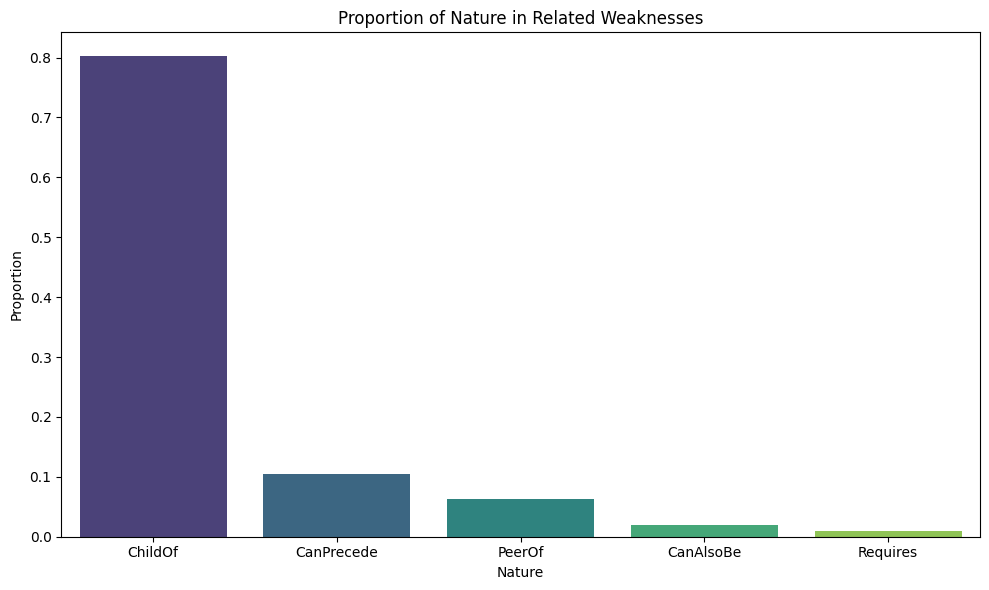

In [16]:
rw_distr = rwn_distribution(jview1000_complete, "1000", True)

,Usage,Count
0,Allowed,752
1,Allowed-with-Review,87
2,Prohibited,59
3,Discouraged,42


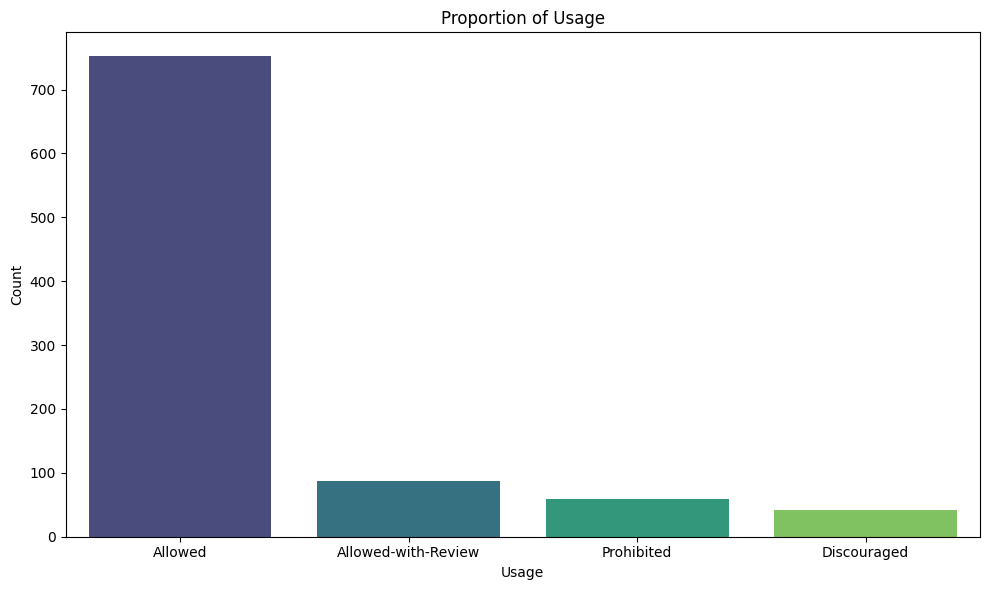

MappingNotes_Usage
Allowed                752
Allowed-with-Review     87
Prohibited              59
Discouraged             42
Name: count, dtype: int64

In [17]:
usage_distribution(jview1000_complete)

,Abstraction,Count
0,Base,521
1,Variant,292
2,Class,110
3,Pillar,10
4,Compound,7


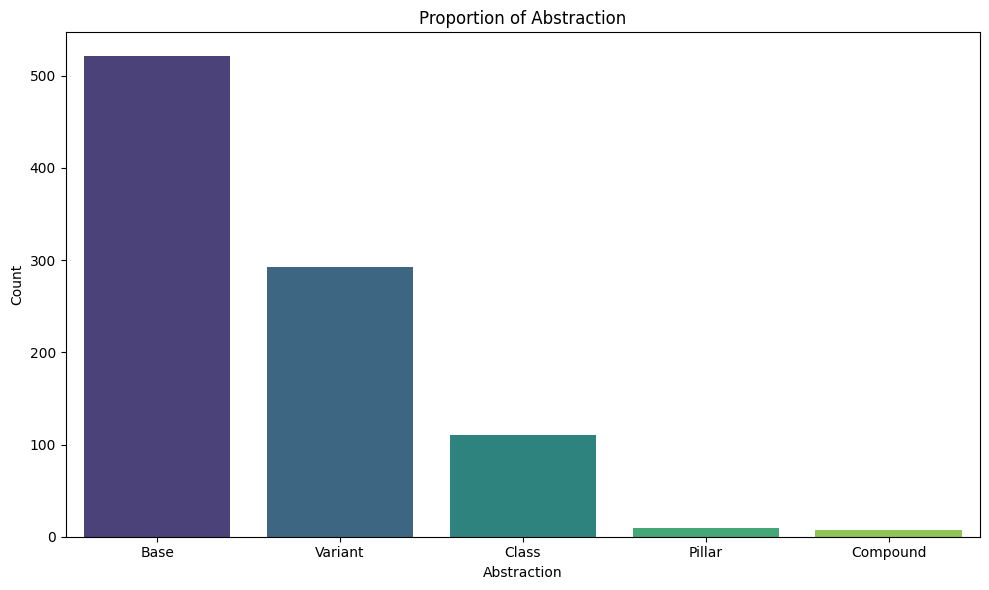

Abstraction
Base        521
Variant     292
Class       110
Pillar       10
Compound      7
Name: count, dtype: int64

In [82]:
abstraction_distr(jview1000_complete)

In [18]:
view_max_depth(jview1000_complete, "1000")

5

In [24]:
extend_desc_num = len(
    df_view1000_complete[df_view1000_complete.ExtendedDescription.notna()]
)
print("Number of CWEs with extended description:", extend_desc_num)
print("Ratio:", str(extend_desc_num / len(df_view1000_complete) * 100) + "%")

Number of CWEs with extended description: 688
Ratio: 73.19148936170212%


In [26]:
df_view1000_complete.head(1)

,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,ApplicablePlatforms,AlternateTerms,ModesOfIntroduction,...,RelatedWeaknesses,WeaknessOrdinalities,DetectionMethods,DemonstrativeExamples,FunctionalAreas,Diagram,LikelihoodOfExploit,BackgroundDetails,NumPaths,Paths
0,284,Improper Access Control,Pillar,Simple,Incomplete,The product does not restrict or incorrectly r...,\n\nAccess control involves the use of several...,"[{'Type': 'Technology', 'Class': 'Not Technolo...","[{'Term': 'Authorization', 'Description': 'The...","[{'Phase': 'Architecture and Design'}, {'Phase...",...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,[[284]]


In [ ]:
import statistics as stat
from prettytable import PrettyTable


def abstraction_tree_stats(cwe_df, view):
    pillar_ch_counts = [
        len(ch_list)
        for ch_list in cwe_df.loc[cwe_df.Abstraction == "Pillar", "Children"].to_list()
    ]
    class_ch_counts = [
        len(ch_list)
        for ch_list in cwe_df.loc[cwe_df.Abstraction == "Class", "Children"].to_list()
    ]
    base_ch_counts = [
        len(ch_list)
        for ch_list in cwe_df.loc[cwe_df.Abstraction == "Base", "Children"].to_list()
    ]
    variant_ch_counts = [
        len(ch_list)
        for ch_list in cwe_df.loc[cwe_df.Abstraction == "Variant", "Children"].to_list()
    ]
    compound_ch_counts = [
        len(ch_list)
        for ch_list in cwe_df.loc[
            cwe_df.Abstraction == "Compound", "Children"
        ].to_list()
    ]

    table = PrettyTable(
        [
            "Abstraction",
            "Count",
            "Mean child count",
            "Median child count",
            "Max child count",
            "Min child count",
        ]
    )
    table.title = "CWE view-" + view + " tree stats"
    table.add_rows(
        [
            [
                "Pillar",
                str(len(pillar_ch_counts)),
                "{:.2f}".format(stat.mean(pillar_ch_counts)),
                "{:.2f}".format(stat.median(pillar_ch_counts)),
                str(max(pillar_ch_counts)),
                str(min(pillar_ch_counts)),
            ],
            [
                "Class",
                str(len(class_ch_counts)),
                "{:.2f}".format(stat.mean(class_ch_counts)),
                "{:.2f}".format(stat.median(class_ch_counts)),
                str(max(class_ch_counts)),
                str(min(class_ch_counts)),
            ],
            [
                "Base",
                str(len(base_ch_counts)),
                "{:.2f}".format(stat.mean(base_ch_counts)),
                "{:.2f}".format(stat.median(base_ch_counts)),
                str(max(base_ch_counts)),
                str(min(base_ch_counts)),
            ],
            [
                "Variant",
                str(len(variant_ch_counts)),
                "{:.2f}".format(stat.mean(variant_ch_counts)),
                "{:.2f}".format(stat.median(variant_ch_counts)),
                str(max(variant_ch_counts)),
                str(min(variant_ch_counts)),
            ],
            [
                "Compound",
                str(len(compound_ch_counts)),
                "{:.2f}".format(stat.mean(compound_ch_counts)),
                "{:.2f}".format(stat.median(compound_ch_counts)),
                str(max(compound_ch_counts)),
                str(min(compound_ch_counts)),
            ],
        ]
    )
    return table


display(abstraction_tree_stats(df_view1003_complete, "1003"))
display(abstraction_tree_stats(df_view1000_complete, "1000"))

Abstraction,Count,Mean child count,Median child count,Max child count,Min child count
Pillar,2,2.50,2.50,5,0
Class,40,2.20,1.50,9,0
Base,81,0.00,0.00,0,0
Variant,5,0.00,0.00,0,0
Compound,2,0.00,0.00,0,0


Abstraction,Count,Mean child count,Median child count,Max child count,Min child count
Pillar,10,17.90,12.50,41,4
Class,110,5.17,4.00,30,0
Base,521,0.58,0.00,15,0
Variant,292,0.09,0.00,5,0
Compound,7,0.00,0.00,0,0
